In [ ]:
### Good Anomaly Detection - I like what I see 

https://github.com/chickenbestlover/RNN-Time-series-Anomaly-Detection

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization important

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

In [6]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

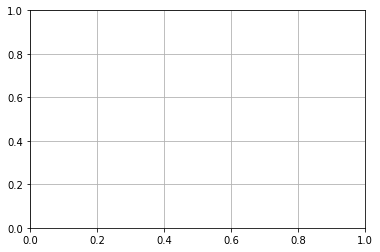

In [7]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
plt.grid(True)

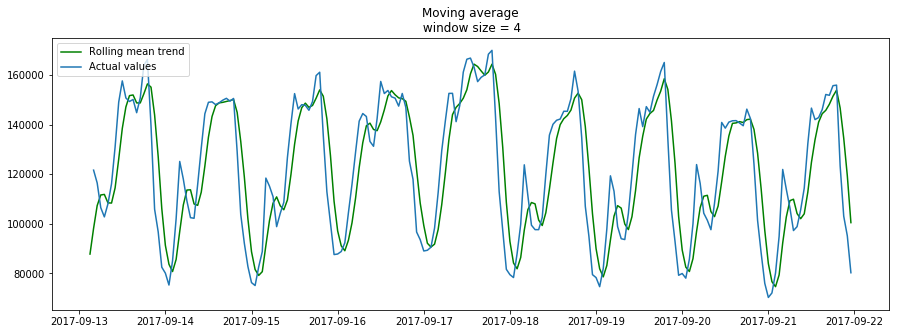

In [8]:
plotMovingAverage(ads, 4) # The data is presented in hourly format 

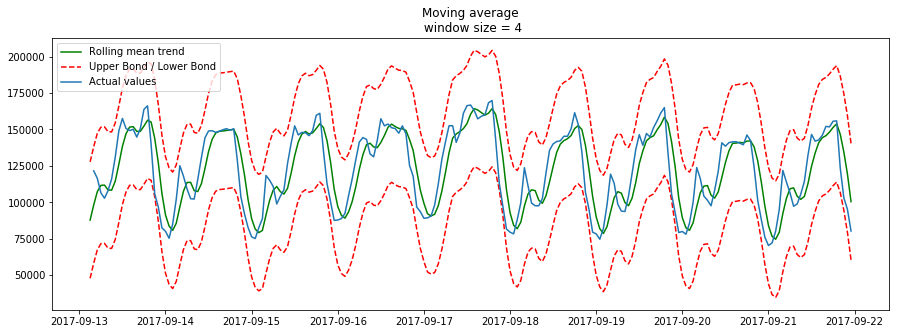

In [10]:
plotMovingAverage(ads, 4, plot_intervals=True)

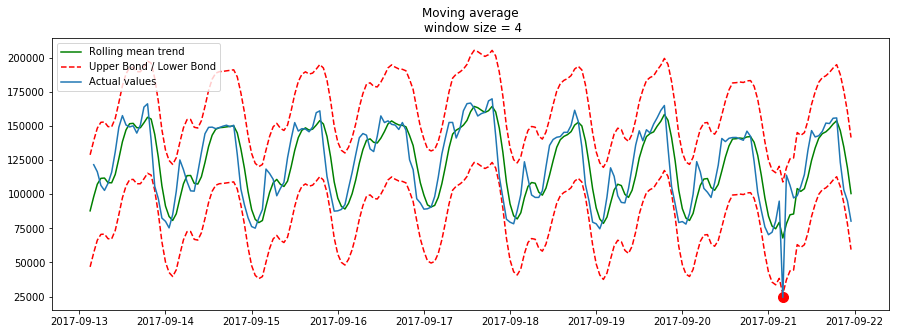

In [11]:
# Creating Anomaly and Plotting 
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

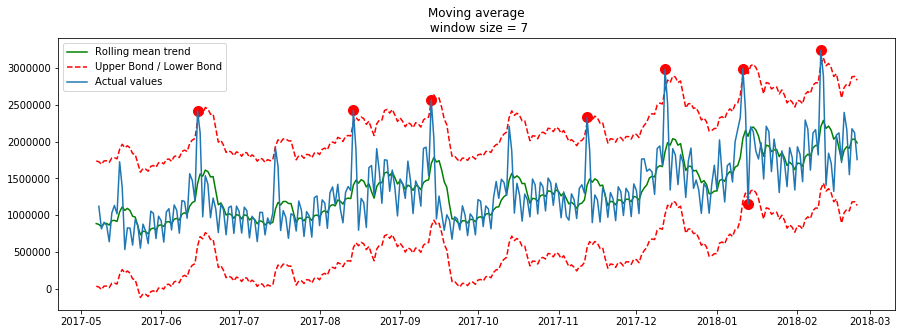

In [14]:
## It doesn't catch shorter term trends or monthly seasonality 
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

In [19]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [16]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [20]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 2.01 s, sys: 19.4 ms, total: 2.03 s
Wall time: 2.05 s


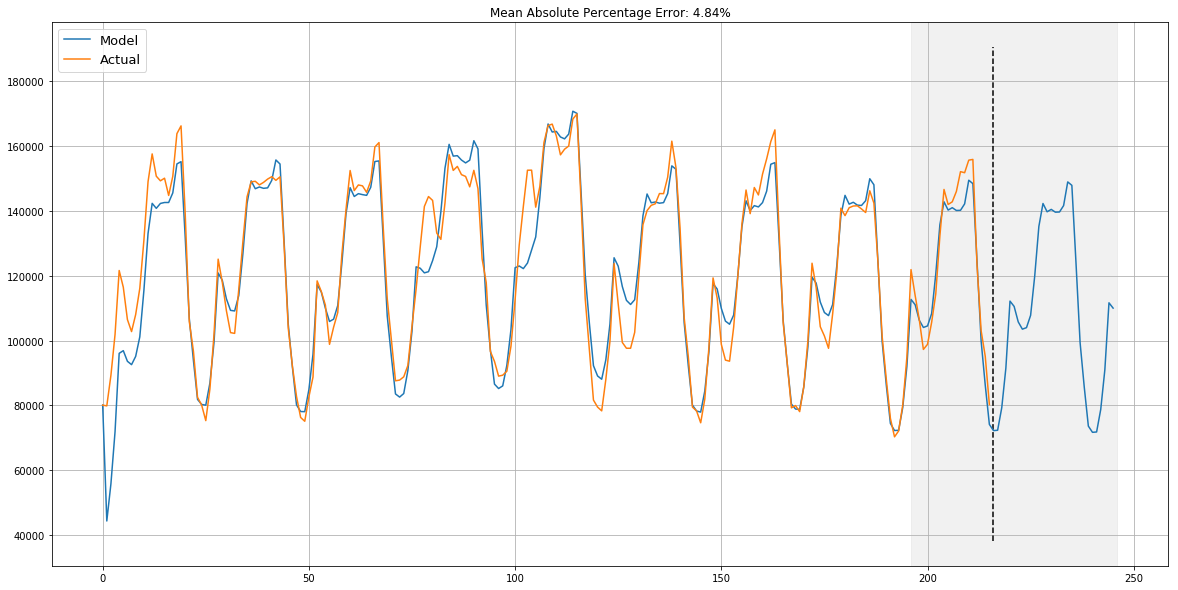

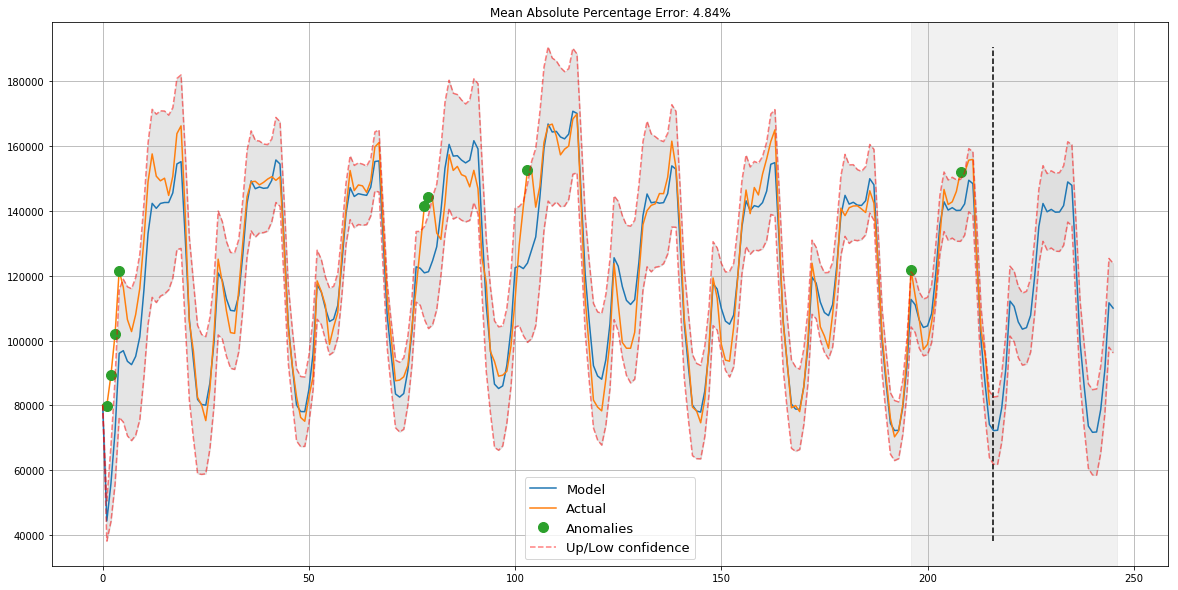

In [21]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

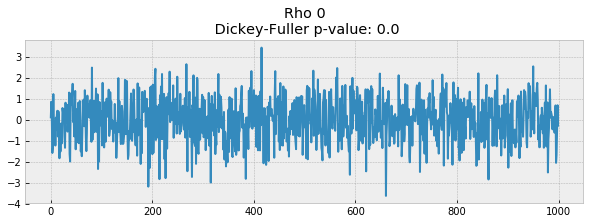

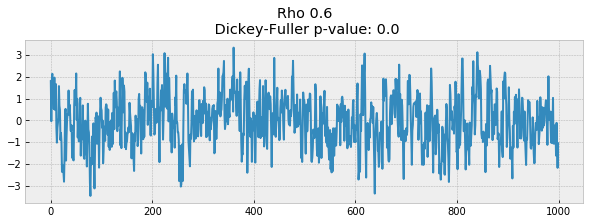

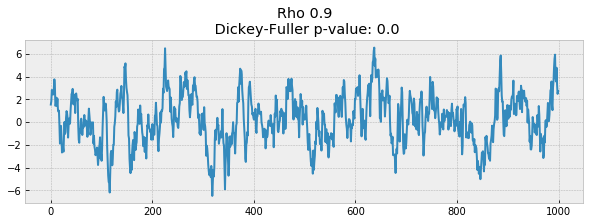

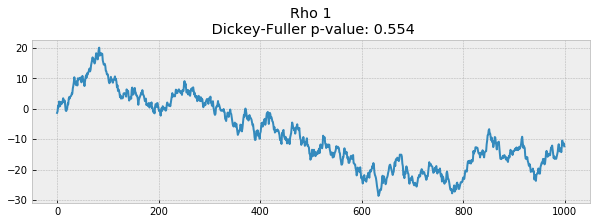

In [26]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

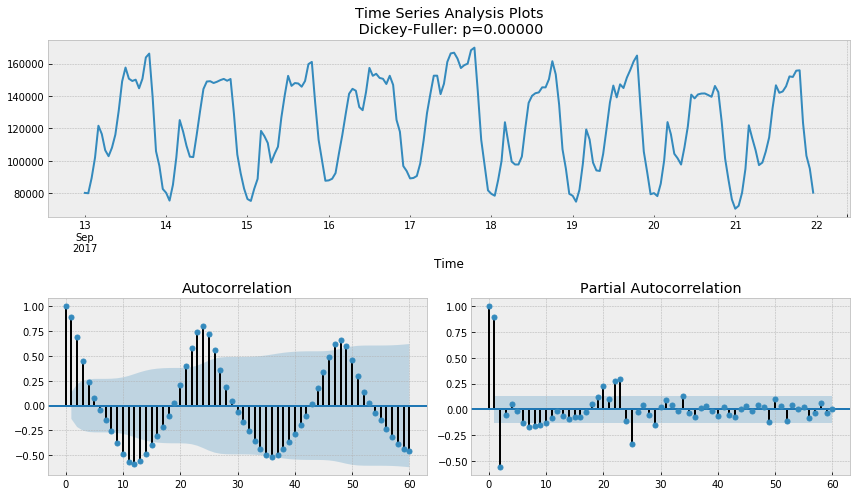

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ads.Ads, lags=60)

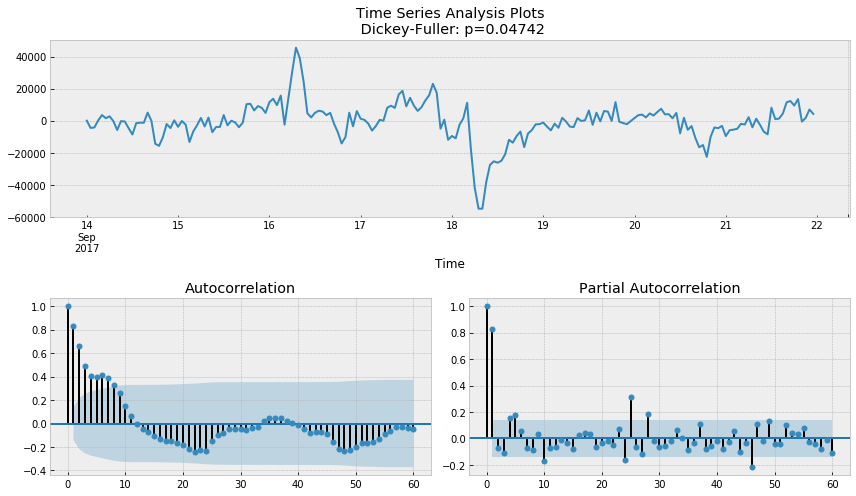

In [29]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

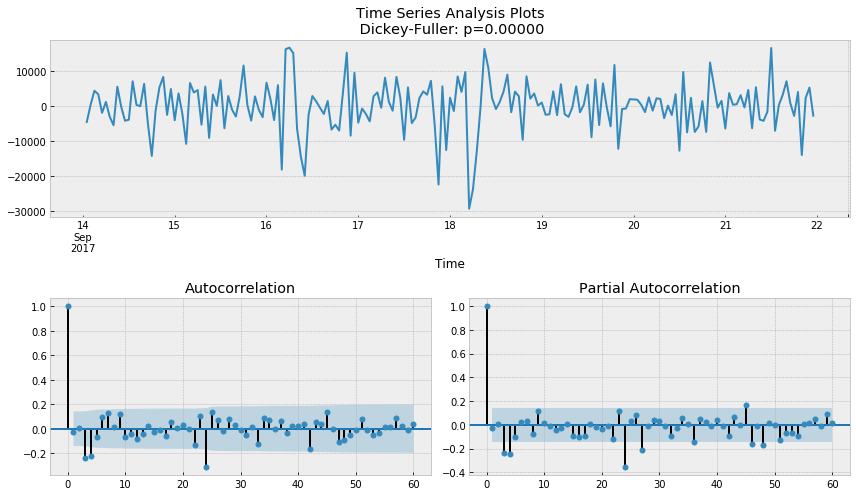

In [30]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

In [32]:
# Shit I can do SARIMA no issue
## Using the above Heuristics, you can test multiple values and see what is better, unlike HOlt-Winters these
## Values can differ tremendously hence the previous deliveration.

In [33]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [35]:
#interesting modelselection based on AIC

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [39]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

HBox(children=(IntProgress(value=0, max=54), HTML(value='')))


CPU times: user 48.2 s, sys: 1.32 s, total: 49.6 s
Wall time: 30 s


In [40]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(4, 1, 2)x(0, 1, 1, 24)   Log Likelihood               -1941.537
Date:                            Mon, 28 May 2018   AIC                           3899.074
Time:                                    07:24:29   BIC                           3926.076
Sample:                                09-13-2017   HQIC                          3909.983
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3135      0.650      0.482      0.630      -0.960       1.587
ar.L2         -0.2554      0.436   

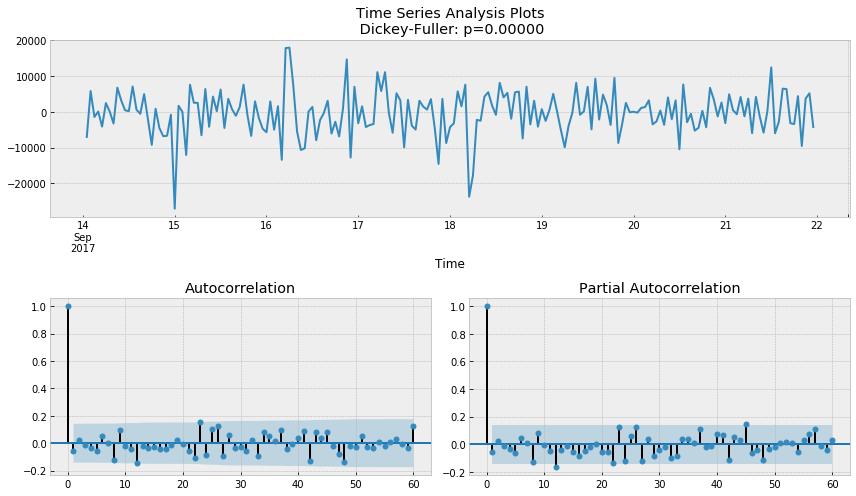

In [41]:
#Let’s inspect the residuals of the model
tsplot(best_model.resid[24+1:], lags=60)

In [129]:
data = ads.copy()
data.columns = ['actual']
data['arima_model'] = best_model.fittedvalues
# making a shift on s+d steps, because these values were unobserved by the model
# due to the differentiating
data['arima_model'][:s+d] = np.NaN

# forecasting on n_steps forward 
forecast = best_model.predict(start = data.shape[0], end = data.shape[0]+50)
forecast = data.arima_model.append(forecast)

In [132]:
forecast.index

DatetimeIndex(['2017-09-13 00:00:00', '2017-09-13 01:00:00',
               '2017-09-13 02:00:00', '2017-09-13 03:00:00',
               '2017-09-13 04:00:00', '2017-09-13 05:00:00',
               '2017-09-13 06:00:00', '2017-09-13 07:00:00',
               '2017-09-13 08:00:00', '2017-09-13 09:00:00',
               ...
               '2017-09-23 17:00:00', '2017-09-23 18:00:00',
               '2017-09-23 19:00:00', '2017-09-23 20:00:00',
               '2017-09-23 21:00:00', '2017-09-23 22:00:00',
               '2017-09-23 23:00:00', '2017-09-24 00:00:00',
               '2017-09-24 01:00:00', '2017-09-24 02:00:00'],
              dtype='datetime64[ns]', length=267, freq=None)

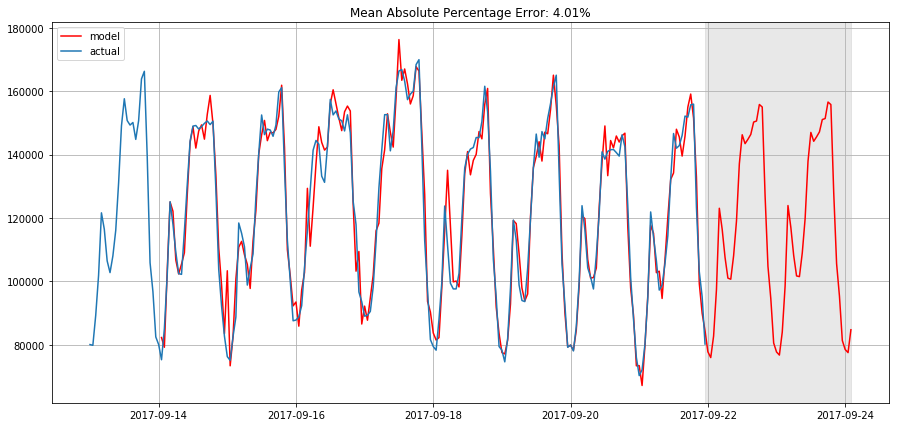

In [42]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ads, best_model, 50)

In [43]:
## I quite like the idea of regressing on past lags.

In [46]:
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

In [47]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [48]:
ads2 =ads.reset_index()

In [55]:
ads2.columns = ['ds', 'y']

In [74]:
prediction_size = 50
train_df = ads2[:-prediction_size]
train_df.tail(n=3)

,ds,y
163,2017-09-19 19:00:00,165010
164,2017-09-19 20:00:00,134090
165,2017-09-19 21:00:00,105585


In [75]:
m = Prophet()
m.fit(train_df);

In [76]:
future = m.make_future_dataframe(freq='H',periods=prediction_size)
future.tail(n=3)

,ds
213,2017-09-21 21:00:00
214,2017-09-21 22:00:00
215,2017-09-21 23:00:00


In [77]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yhat
213,2017-09-21 21:00:00,105006.982700,103518.030014,106581.790120,84003.376013,106933.655023,-9269.979077,-9269.979077,-9269.979077,-9269.979077,-9269.979077,-9269.979077,-9269.979077,-9269.979077,-9269.979077,95737.003623
214,2017-09-21 22:00:00,104786.681558,103248.798916,106409.695023,64835.742210,87444.157296,-28570.732640,-28570.732640,-28570.732640,-28570.732640,-28570.732640,-28570.732640,-28570.732640,-28570.732640,-28570.732640,76215.948917
215,2017-09-21 23:00:00,104566.380415,102968.989417,106255.495488,52263.346662,74834.313915,-41049.453889,-41049.453889,-41049.453889,-41049.453889,-41049.453889,-41049.453889,-41049.453889,-41049.453889,-41049.453889,63516.926527


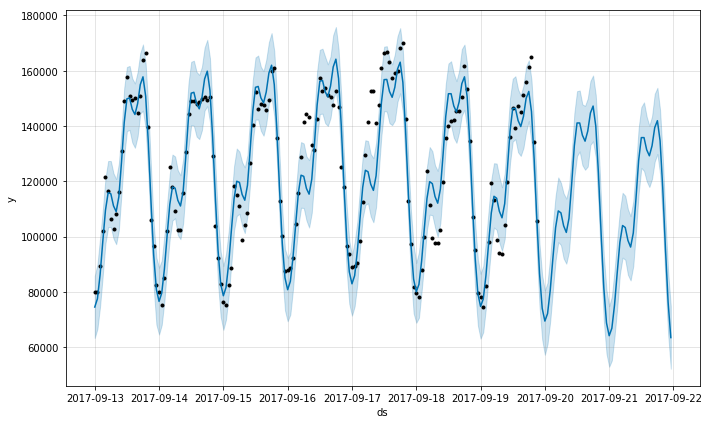

In [78]:
m.plot(forecast);

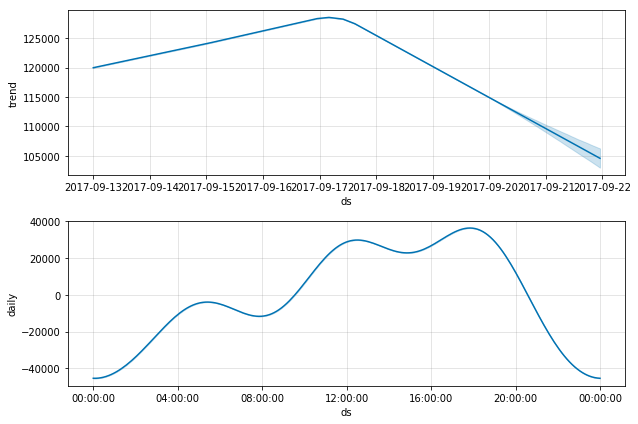

In [79]:
m.plot_components(forecast);

In [80]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [81]:
cmp_df = make_comparison_dataframe(ads2, forecast)
cmp_df.tail(n=3)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-09-21 21:00:00,95737.003623,84003.376013,106933.655023,103080
2017-09-21 22:00:00,76215.948917,64835.742210,87444.157296,95155
2017-09-21 23:00:00,63516.926527,52263.346662,74834.313915,80285


In [82]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [83]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [84]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 200, 'New posts on Medium')

In [85]:
### This COX is just worth it if there is a lot of variation differences
#i.e. irregular amplitudes over time, which was not my case

def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [86]:
train_df2 = train_df.copy().set_index('ds')

In [88]:
from scipy import stats
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

In [95]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(freq='H',periods=prediction_size)
forecast2 = m2.predict(future2)

In [96]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column],
                                       lambda_prophet)

In [97]:
cmp_df2 = make_comparison_dataframe(ads2, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
     print(err_name, err_value)

MAPE 6.492500976556841
MAE 7134.866532886202


In [98]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

In [99]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [ ]:
https://github.com/maxim5/time-series-machine-learning


In [107]:
ads2.head()

,ds,y
0,2017-09-13 00:00:00,80115
1,2017-09-13 01:00:00,79885
2,2017-09-13 02:00:00,89325
3,2017-09-13 03:00:00,101930
4,2017-09-13 04:00:00,121630


In [114]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
import numpy
from numpy import concatenate

In [115]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, timesteps):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], timesteps, 1)
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, len(X), 1)
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# run a repeated experiment
def experiment(repeats, series, timesteps):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, timesteps)
	supervised_values = supervised.values[timesteps:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1, timesteps)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores
 
    

In [124]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%b')
series = read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [125]:
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64

In [127]:
# execute the experiment
def run():
	# load dataset
	series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = pd.DataFrame()
	# run experiment
	timesteps = 1
	#series = ads2
	results['results'] = experiment(repeats, series, timesteps)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_timesteps_1.csv', index=False)
 
 # entry point
run()

1) Test RMSE: 146.245
2) Test RMSE: 187.645
3) Test RMSE: 89.678
4) Test RMSE: 111.860
5) Test RMSE: 128.445
6) Test RMSE: 111.310
7) Test RMSE: 127.272
8) Test RMSE: 114.537
9) Test RMSE: 145.004
10) Test RMSE: 108.287
          results
count   10.000000
mean   127.028272
std     27.382518
min     89.678038
25%    111.447343
50%    120.904695
75%    140.863782
max    187.644514


In [ ]:
## LTSM is not going to work on this small dataset I have tried.

In [ ]:
### You know this is for multiple features - So I wont be looking at it for now - But for the futreaaa

Epoch 1/25
70/70 [==============================] - 3s 40ms/step - loss: 0.2020
Epoch 2/25
70/70 [==============================] - 2s 26ms/step - loss: 0.0391: 
Epoch 3/25
70/70 [==============================] - 2s 22ms/step - loss: 0.0379
Epoch 4/25
70/70 [==============================] - 2s 23ms/step - loss: 0.0329
Epoch 5/25
70/70 [==============================] - 2s 22ms/step - loss: 0.0194
Epoch 6/25
70/70 [==============================] - 2s 23ms/step - loss: 0.0246: 0s - lo
Epoch 7/25
70/70 [==============================] - 2s 22ms/step - loss: 0.0207: 0s - loss: 0.0 - ETA: 0s - loss: 0.0
Epoch 8/25
70/70 [==============================] - 2s 22ms/step - loss: 0.0251
Epoch 9/25
70/70 [==============================] - 1s 21ms/step - loss: 0.0215
Epoch 10/25
70/70 [==============================] - 2s 23ms/step - loss: 0.0236
Epoch 11/25
70/70 [==============================] - 2s 22ms/step - loss: 0.0221
Epoch 12/25
70/70 [==============================] - 1s 21ms/step - l

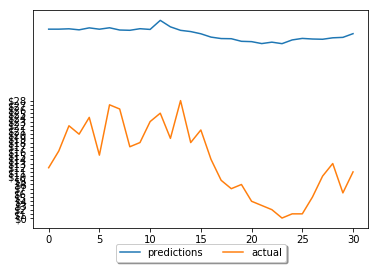

prediction data
[45.035786 45.035786 45.12472  44.87574  45.34673  45.02776  45.369022
 44.83299  44.767593 45.144344 44.974773 47.133514 45.5902   44.756805
 44.46293  43.9379   43.14366  42.798065 42.759125 42.140377 42.062378
 41.600746 41.938652 41.58255  42.46898  42.833443 42.68793  42.63052
 42.97553  43.0805   43.96334 ]
x_test_all
['43.849998\xa0\xa0' '44.93\xa0\xa0' '45.330002\xa0\xa0'
 '45.209999\xa0\xa0' '45.470001\xa0\xa0' '44.889999\xa0\xa0'
 '45.880001\xa0\xa0' '45.759998\xa0\xa0' '45.02\xa0\xa0'
 '45.119999\xa0\xa0' '45.349998\xa0\xa0' '45.610001\xa0\xa0'
 '45.150002\xa0\xa0' '46.48\xa0\xa0' '45.119999\xa0\xa0' '45.25\xa0\xa0'
 '44.639999\xa0\xa0' '43.369999\xa0\xa0' '42.98\xa0\xa0'
 '43.130001\xa0\xa0' '42.599998\xa0\xa0' '42.34\xa0\xa0'
 '42.139999\xa0\xa0' '41.700001\xa0\xa0' '42.110001\xa0\xa0'
 '42.110001\xa0\xa0' '42.66\xa0\xa0' '43.57\xa0\xa0' '43\xa0'
 '42.860001\xa0\xa0' '43.599998\xa0\xa0']
train_mse
[0.018487647384193093, 0.027381492728937928, 0.0419108567814

In [106]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
 
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
 
import matplotlib.pyplot as plt
 
 
fname="data/stock_data.csv"
data_csv = pd.read_excel (fname)
 
#how many data we will use 
# (should not be more than dataset length )
data_to_use= 100
 
# number of training data
# should be less than data_to_use
train_end =70
 
 
total_data=len(data_csv)
 
#most recent data is in the end 
#so need offset
start=total_data - data_to_use
 
 
#currently doing prediction only for 3 steps ahead
steps_to_predict = 3
train_mse=[]
test_mse=[]
forecast=[]
for i in range(steps_to_predict):
    train_mse.append(0)
    test_mse.append(0)
    forecast.append(0)
 
 
yt = data_csv.iloc [start:total_data ,4]    #Close price
yt1 = data_csv.iloc [start:total_data ,1]   #Open
yt2 = data_csv.iloc [start:total_data ,2]   #High
yt3 = data_csv.iloc [start:total_data ,3]   #Low
vt = data_csv.iloc [start:total_data ,6]    # volume
 
 
     
for i in range(steps_to_predict):
     
    if i==0:
        units=20
        batch_size=1
    if i==1:
        units=15
        batch_size=1
    if i==2:
         units=80
        batch_size=1
     
         
 
    yt_ = yt.shift (-i - 1  )   
 
    data = pd.concat ([yt, yt_, vt, yt1, yt2, yt3], axis =1)
    data. columns = ['yt', 'yt_', 'vt', 'yt1', 'yt2', 'yt3']
     
    data = data.dropna()
     
    
     
# target variable - closed price
    y = data ['yt_']
 
        
#       closed,  volume,   open,  high,   low    
    cols =['yt',    'vt',  'yt1', 'yt2', 'yt3']
    x = data [cols]
 
   
    
    scaler_x = preprocessing.MinMaxScaler ( feature_range =( -1, 1))
    x = np. array (x).reshape ((len( x) ,len(cols)))
    x = scaler_x.fit_transform (x)
 
    
    scaler_y = preprocessing. MinMaxScaler ( feature_range =( -1, 1))
    y = np.array (y).reshape ((len( y), 1))
    y = scaler_y.fit_transform (y)
 
 
 
     
    x_train = x [0: train_end,]
 
 
    x_test = x[ train_end +1:len(x),]    
    y_train = y [0: train_end] 
 
 
 
    y_test = y[ train_end +1:len(y)]  
                
    if (i == 0) :     
        prediction_data=[]
        for j in range (len(y_test) - 0 ) :
               prediction_data.append (0)       
 
 
 
    x_train = x_train.reshape (x_train. shape + (1,)) 
    x_test = x_test.reshape (x_test. shape + (1,))
 
     
     
 
     
 
 
    seed =2018
    np.random.seed (seed)
     
##############
##  i=0
##############
    if i == 0 :
          fit0 = Sequential ()
          fit0.add (LSTM (  units , activation = 'tanh', inner_activation = 'hard_sigmoid' , input_shape =(len(cols), 1) ))
          fit0.add(Dropout(0.2))
          fit0.add (Dense (output_dim =1, activation = 'linear'))
          fit0.compile (loss ="mean_squared_error" , optimizer = "adam")  
    
          fit0.fit (x_train, y_train, batch_size =batch_size, nb_epoch =25, shuffle = False)
          train_mse[i] = fit0.evaluate (x_train, y_train, batch_size =batch_size)
          test_mse[i] = fit0.evaluate (x_test, y_test, batch_size =batch_size)
          pred = fit0.predict (x_test) 
          pred = scaler_y.inverse_transform (np. array (pred). reshape ((len( pred), 1)))
             # below is just fo i == 0
          for j in range (len(pred) - 0 ) :
                   prediction_data[j] = pred[j] 
                   
              
                
          forecast[i]=pred[-1]
          
                   
#############
##  i=1
#############
    if i == 1 :    
          fit1 = Sequential ()
          fit1.add (LSTM (  units , activation = 'tanh', inner_activation = 'hard_sigmoid' , input_shape =(len(cols), 1) ))
          fit1.add(Dropout(0.2))
          fit1.add (Dense (output_dim =1, activation = 'linear'))
          fit1.compile (loss ="mean_squared_error" , optimizer = "adam")  
          fit1.fit (x_train, y_train, batch_size =batch_size, nb_epoch =25, shuffle = False)
          train_mse[i] = fit1.evaluate (x_train, y_train, batch_size =batch_size)
          test_mse[i] = fit1.evaluate (x_test, y_test, batch_size =batch_size)
          pred = fit1.predict (x_test) 
          pred = scaler_y.inverse_transform (np. array (pred). reshape ((len( pred), 1)))
          forecast[i]=pred[-1]
         
           
        
#############
##  i=2
#############
    if i==2 :
          fit2 = Sequential ()
          fit2.add (LSTM (  units , activation = 'tanh', inner_activation = 'hard_sigmoid' , input_shape =(len(cols), 1) ))
          fit2.add(Dropout(0.2))
          fit2.add (Dense (output_dim =1, activation = 'linear'))
          fit2.compile (loss ="mean_squared_error" , optimizer = "adam")  
          fit2.fit (x_train, y_train, batch_size =batch_size, nb_epoch =25, shuffle = False)
          train_mse[i] = fit2.evaluate (x_train, y_train, batch_size =batch_size)
          test_mse[i] = fit2.evaluate (x_test, y_test, batch_size =batch_size)
          pred = fit2.predict (x_test) 
          pred = scaler_y.inverse_transform (np. array (pred). reshape ((len( pred), 1)))
               
          forecast[i]=pred[-1]
  
 
    x_test = scaler_x.inverse_transform (np. array (x_test). reshape ((len( x_test), len(cols))))
    
prediction_data = np.asarray(prediction_data)
prediction_data = prediction_data.ravel()
 
 
 
for j in range (len(prediction_data) - 1 ):
    prediction_data[len(prediction_data) - j - 1  ] =  prediction_data[len(prediction_data) - 1 - j - 1]
 
 
prediction_data = np.append(prediction_data, forecast)
 
x_test_all = yt[len(yt)-len(prediction_data)-1:len(yt)-1]
x_test_all = x_test_all.ravel()                
 
plt.plot(prediction_data, label="predictions")
plt.plot(  x_test_all, label="actual")
 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
 
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)
ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
 
 
plt.show()
 
 
print ("prediction data")
print ((prediction_data))
 
print ("x_test_all")
print ((x_test_all))
 
print ("train_mse")
print (train_mse)
 
print ("test_mse")
print (test_mse)